In [ ]:
!pip install transformers

In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.33.0
Uninstalling transformers-4.33.0:
  Successfully uninstalled transformers-4.33.0
Found existing installation: accelerate 0.22.0
Uninstalling accelerate-0.22.0:
  Successfully uninstalled accelerate-0.22.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 54.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 82.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3


In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForPreTraining,AutoModel

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from IPython.display import clear_output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split as tts
import scikitplot as skplt

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

np.random.seed(42)
random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 62.9 MB/s eta 0:00:0000:0100:01
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# EDA

In [ ]:
data = pd.read_json('/kaggle/input/work-multi/subtaskA_train_multilingual.jsonl', lines=True)
data.sample(10)

,text,label,model,source,id
131612,The coat of arms of Romania was adopted in the...,0,human,wikipedia,131612
62951,Chignons have been a classic hairstyle for cen...,1,chatGPT,wikihow,62951
18246,The 1964 All-Ireland Minor Hurling Championsh...,1,davinci,wikipedia,18246
47659,Peugeot се опитва да краси моята предстояща на...,1,davinci,bulgarian,47659
8286,"Seizures can happen at any age; however, most ...",1,bloomz,wikihow,8286
2319,", This is so that the cabin will easily fit ov...",0,human,wikihow,2319
23803,Much higher than average in both cases. In fac...,1,bloomz,reddit,23803
153894,Wires are full of electricity (all metals are....,0,human,reddit,153894
162598,Sparse model selection by structural risk mi...,0,human,arxiv,162598
43632,Планетата Меркурий е една от най-близките до С...,1,chatGPT,bulgarian,43632


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172417 entries, 0 to 172416
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    172417 non-null  object
 1   label   172417 non-null  int64 
 2   model   172417 non-null  object
 3   source  172417 non-null  object
 4   id      172417 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 6.6+ MB


Удаление NaN

In [ ]:
data = data.dropna()

Взглянем на распределение по классам на всех данных

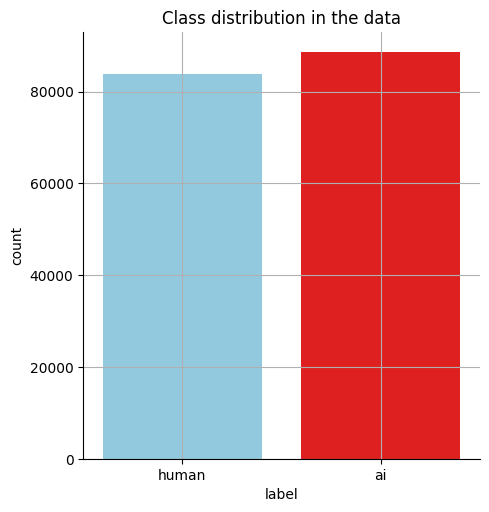

In [ ]:
g = sns.catplot(x='label',
                kind="count",
                data=data.sort_values("label")[::-1],
                palette=sns.color_palette(['skyblue',"red"]))
plt.xticks([0, 1],['human', 'ai'])
plt.grid()
plt.title("Class distribution in the data");

## Лемматизация

In [ ]:
!pip install stop-words

In [ ]:
from stop_words import get_stop_words
bu_stopwords = get_stop_words('bulgarian')
ar_stopwords = get_stop_words('arabic')

In [ ]:
en_stopwords = stopwords.words('english')
ru_stopwords = stopwords.words('russian')
ch_stopwords = stopwords.words('chinese')
in_stopwords = stopwords.words('indonesian')
ge_stopwords = stopwords.words('german')

In [ ]:
mystopwords = bu_stopwords+ar_stopwords+en_stopwords+ru_stopwords+ch_stopwords+in_stopwords

In [ ]:
def remove_stopwords(lemmas, stopwords = en_stopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = text.split()
    return ' '.join(remove_stopwords(tokens))

In [ ]:
from multiprocessing import Pool as PoolSklearn
#train
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, data['text']), total=len(data)))

data['text_lemmas'] = lemmas
data

100%|██████████| 172417/172417 [01:31<00:00, 1891.71it/s]


,text,label,model,source,id,text_lemmas
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0,Forza Motorsport popular racing game provides ...
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1,Buying Virtual Console games Nintendo easy pro...
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2,"Windows popular operating system back day, sti..."
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3,Make Perfume Perfume great enhance personal sc...
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4,Convert Song Lyrics Song' Converting song lyri...
...,...,...,...,...,...,...
172412,"During the Cold War, the United States was po...",1,cohere,reddit,172412,"During Cold War, United States portrayed USSR ..."
172413,"The ""continuity thesis"" is the idea that ther...",1,cohere,reddit,172413,"""continuity thesis"" idea direct line continuit..."
172414,"In the early Middle Ages, the pagan Norse wer...",1,cohere,reddit,172414,"early Middle Ages, pagan Norse known prowess t..."
172415,There are many similarities between the langu...,1,cohere,reddit,172415,There many similarities languages North Americ...


## Визуализация

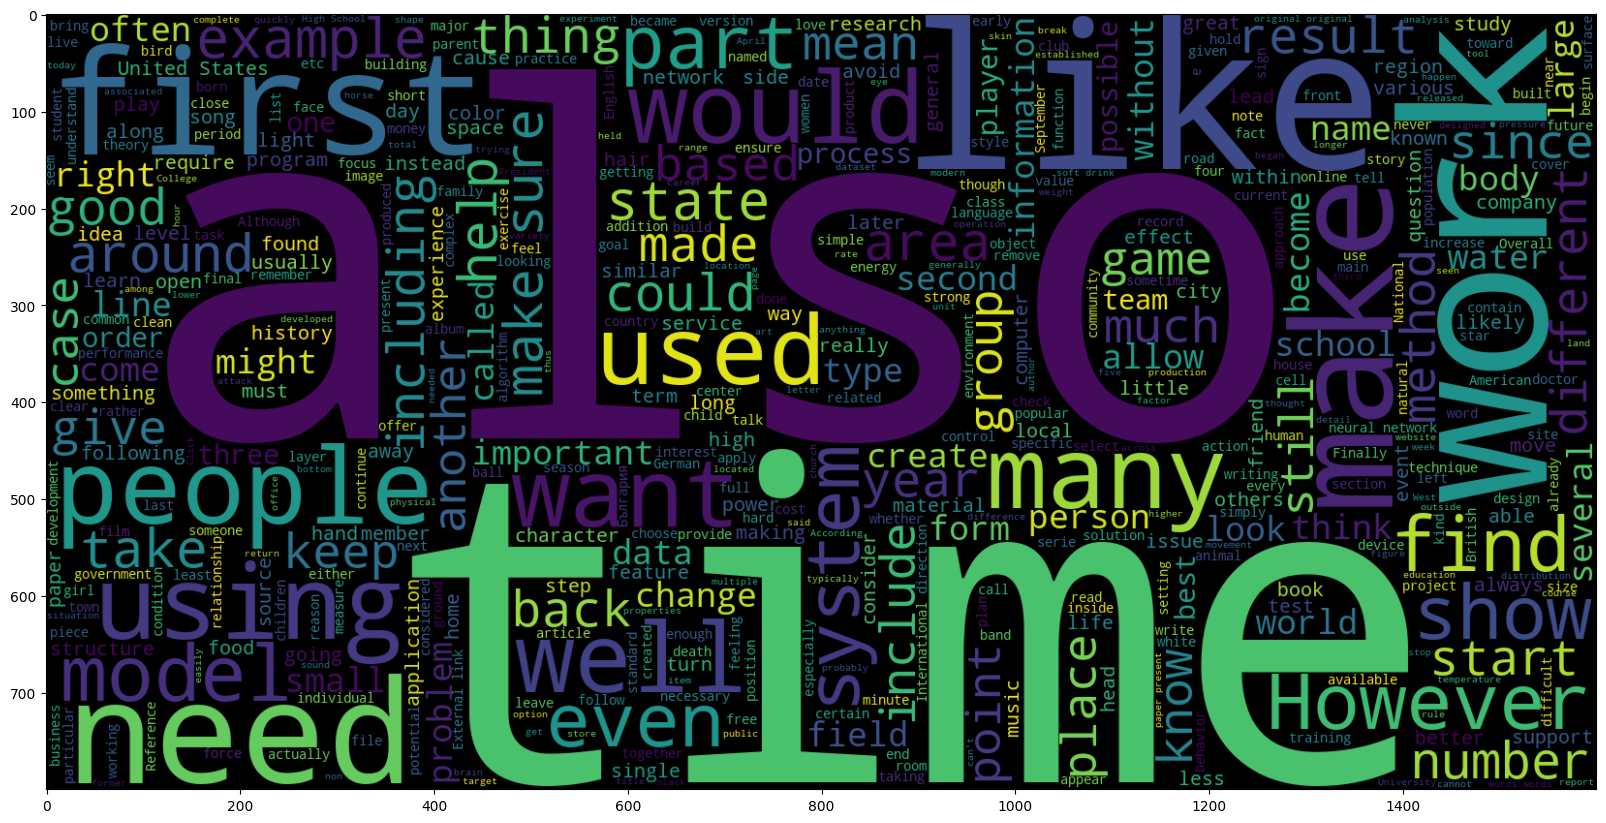

In [ ]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = mystopwords)
wc.generate(' '.join(data.sample(n=5000)['text_lemmas']))
plt.imshow(wc , interpolation = 'bilinear')

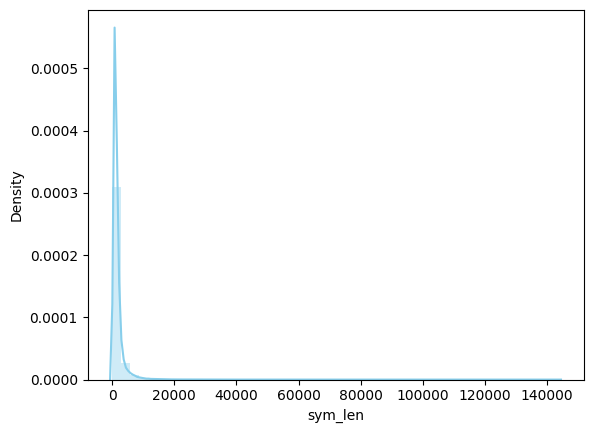

In [ ]:
data['sym_len'] = data.text_lemmas.apply(len)
data['word_len'] = data.text_lemmas.apply(lambda x: len(x.split()))
data = data[data.sym_len > 0]
data = data[data.word_len > 0]
sns.distplot(data["sym_len"] , color="skyblue", label="Symdol Length");

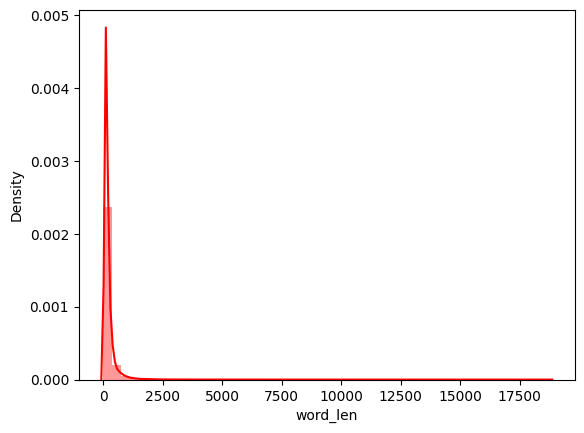

In [ ]:
sns.distplot(data['word_len'] , color="red", label="Word Length");

Види и там и там распределения с длинными хвостами, чтобы исправить этого возбмем логорифм

In [ ]:
data['sym_len'] = np.log(data['sym_len'])
data['word_len'] = np.log(data['word_len'])

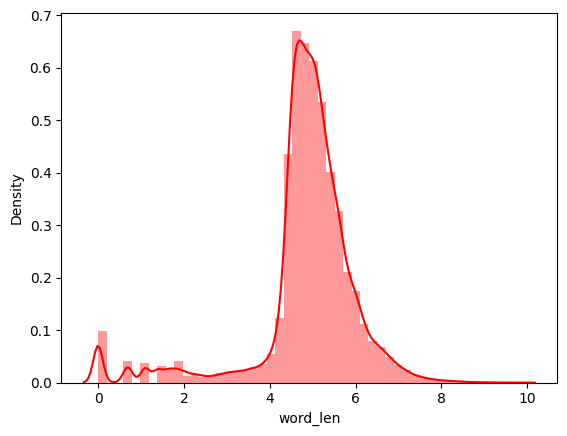

In [ ]:
sns.distplot(data['word_len'] , color="red", label="Word Length");

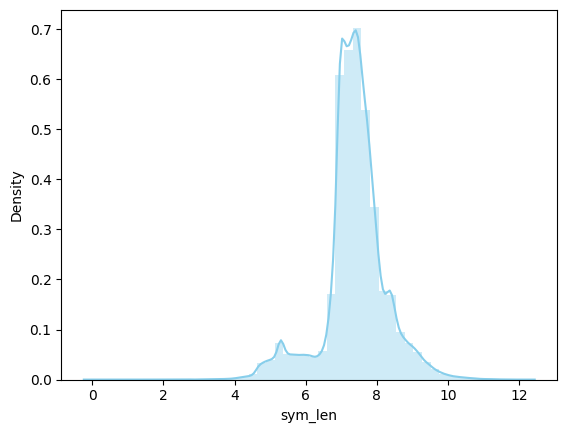

In [ ]:
sns.distplot(data["sym_len"] , color="skyblue", label="Symdol Length");

# Tf-Idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 3),max_features = 5000)
data_vec = vec.fit_transform(data['text_lemmas'])

In [ ]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(n_components=3)
pca.fit(data_vec)

data_2 = pca.transform(data_vec)
df = pd.DataFrame(dict(x=data_2[:,0], y=data_2[:,1], z = data_2[:,2],label=data['label'].tolist()))
groups = df.groupby('label',sort=False)

cluster_colors = {0: 'skyblue',1:  'red'}
cluster_names = {0: 'hu', 1: 'ai'}

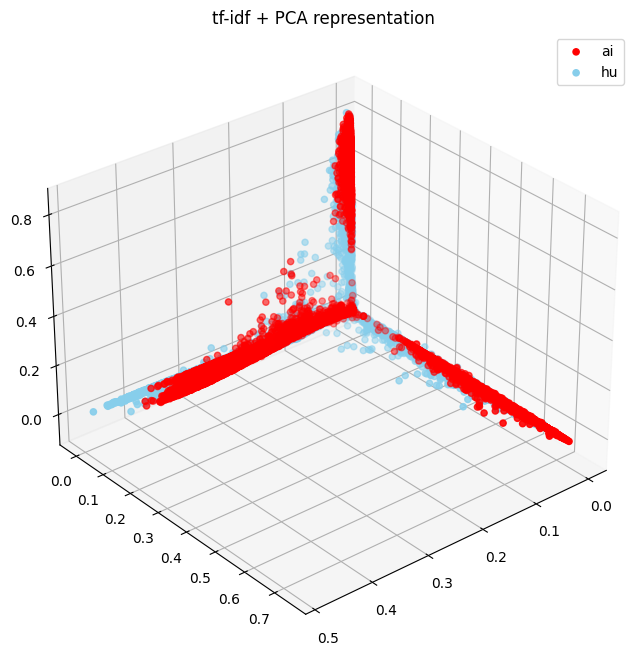

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection = '3d')
for name, group in groups:
    ax.scatter(group.x, group.y, group.z, marker='o', linestyle='', label=cluster_names[name], color=cluster_colors[name])
    ax.set_aspect('auto')
    ax.tick_params(
        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(
        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
ax.view_init(elev=30, azim=50)
plt.grid(which='both')
plt.title('tf-idf + PCA representation')
ax.legend(numpoints=1)
plt.show()

## Tf-idf отбор фич

In [ ]:
X = data[['text','text_lemmas']]
y = data['label']
train, test, y_train, y_test = tts(X, y, stratify=y, train_size=0.7)
vec = TfidfVectorizer(ngram_range=(1, 3),max_features = 5000)

train_vec = vec.fit_transform(train['text_lemmas'])
test_vec = vec.transform(test['text_lemmas'])

In [ ]:
bestfeatures = SelectPercentile(score_func = f_classif)
fit = bestfeatures.fit(train_vec, y_train)

In [ ]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(np.arange(train_vec.shape[1]))
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']
top_n = featureScores.nlargest(25, 'Score')
arr = np.array(top_n['Specs'])
arr_name = vec.get_feature_names_out()

In [ ]:
importance = []
names = []
for i in arr:
    names.append(arr_name[i])
    importance.append(featureScores.Score[i])

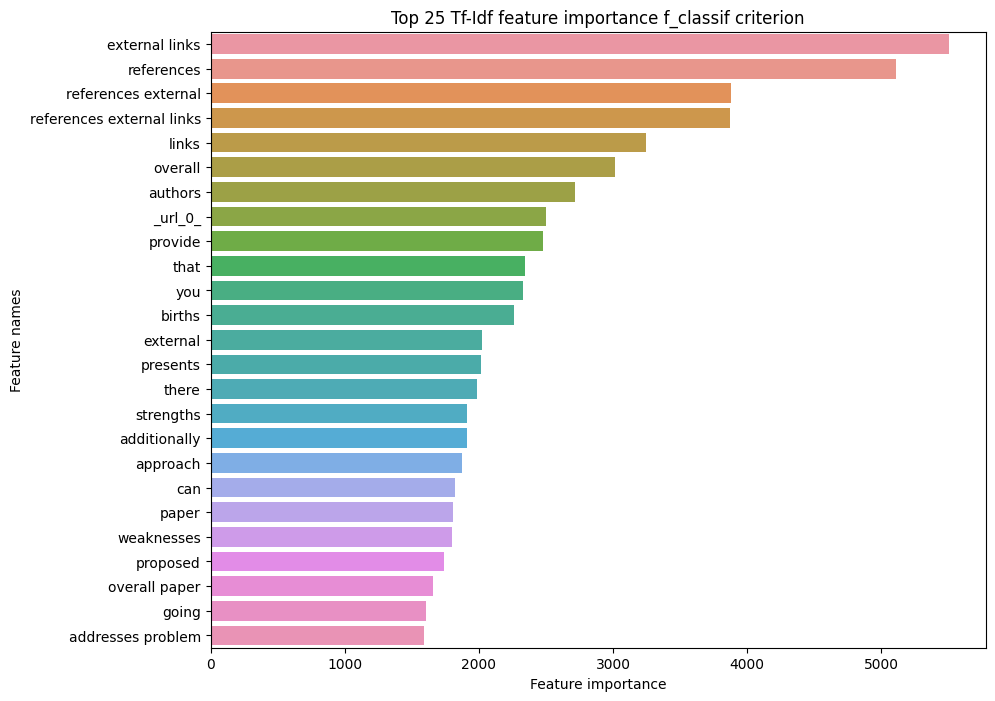

In [ ]:
def plot_feature_importance(importance,names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title('Top 25 Tf-Idf feature importance f_classif criterion')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')
plot_feature_importance(importance,names)

## Tf-idf top25 feature hitmap

In [ ]:
for i in arr:
    train[f'feature_{arr_name[i]}'] = train_vec[:, i].toarray()
train

,text,text_lemmas,feature_external links,feature_references,feature_references external,feature_references external links,feature_links,feature_overall,feature_authors,feature__url_0_,...,feature_strengths,feature_additionally,feature_approach,feature_can,feature_paper,feature_weaknesses,feature_proposed,feature_overall paper,feature_going,feature_addresses problem
76378,"Jakarta, CNN Indonesia -- Tim Ridwan Kamil, Gu...","Jakarta, Indonesia Ridwan Kamil, Gubernur Jawa...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
95818,"The paper titled ""Playing SNES in the Retro Le...","paper titled ""Playing SNES Retro Learning Envi...",0.000000,0.000000,0.000000,0.000000,0.000000,0.039807,0.173383,0.0,...,0.051017,0.048061,0.0,0.0,0.278492,0.052945,0.0,0.0,0.000000,0.0
130801,Sir Horace Walter Cutler (28 July 1912 – 2 Ma...,Horace Walter Cutler July 1912 March 1997) Bri...,0.028723,0.025557,0.031458,0.031469,0.027902,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
57840,iPod shuffle的锂电池第一次充电需要至少充满。这通常需要2-4个小时，具体取决于i...,iPod shuffle的锂电池第一次充电需要至少充满。这通常需要2-4个小时，具体取决于i...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
105173,The authors make several interesting observati...,authors make several interesting observations ...,0.000000,0.086964,0.000000,0.000000,0.000000,0.087790,0.095594,0.0,...,0.112512,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.091147,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42787,\nWe investigate the effects of electron-latti...,investigate effects electron-lattice coupling ...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
143968,A lot of what you're seeing is sensationalized...,seeing sensationalized studies actually suppor...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
72278,We study the exponential scale length of tot...,study exponential scale length total radio emi...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
49788,دنیا بھر میں لوگوں کے دلچسپی کا مرکز، کل کا سو...,دنیا لوگوں دلچسپی مرکز، سورج سورج دیکھتے مشرق ...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


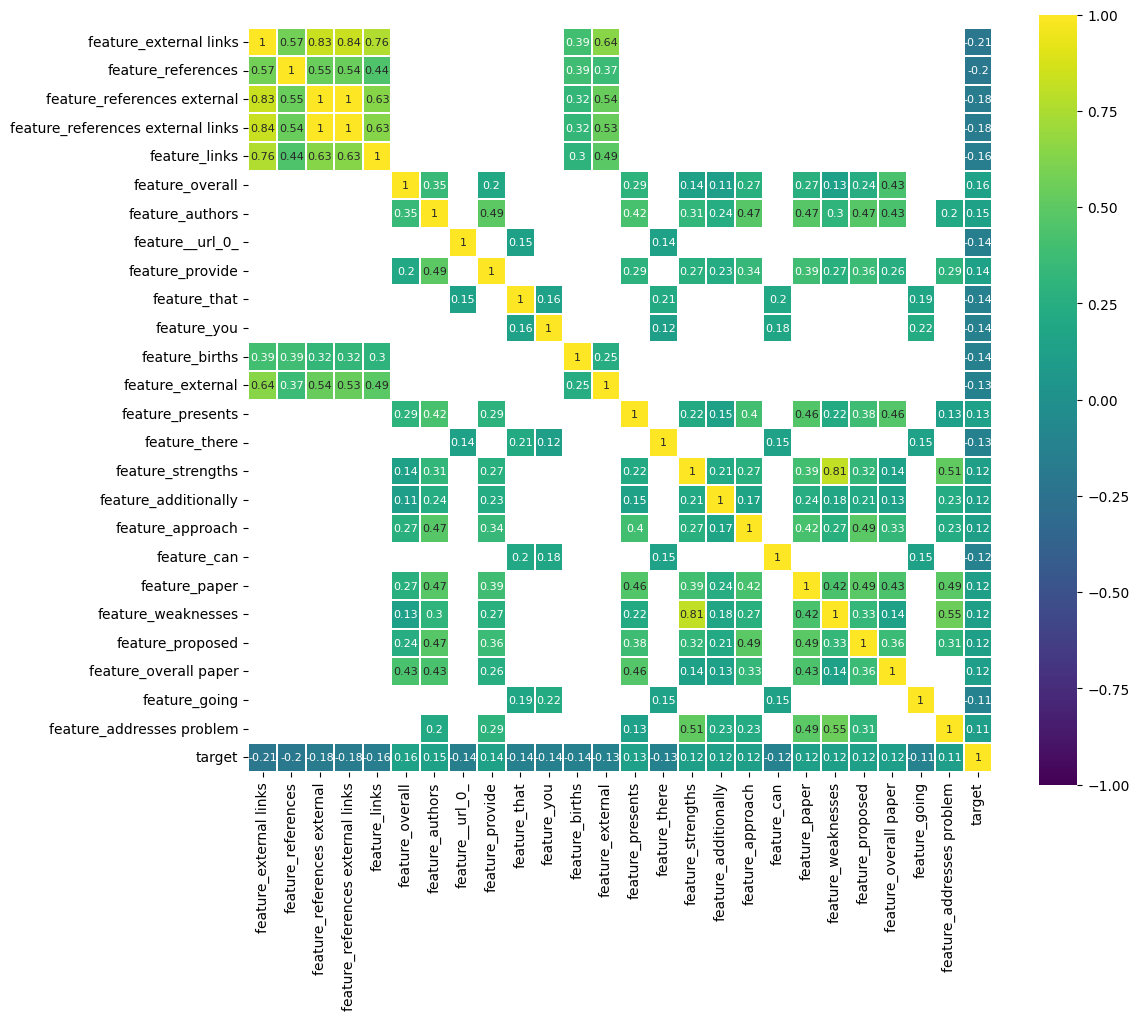

In [ ]:
train['target'] = y
corr = train.drop(columns = ['text','text_lemmas']).corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)], cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,annot=True, annot_kws={"size": 8}, square=True);

# Классификация

In [ ]:
X = data[['text','text_lemmas']]
y = data['label']
train, test, y_train, y_test = tts(X, y,random_state=42, train_size=0.7, shuffle=True)

## mBERT

In [ ]:
model_name = "bert-base-multilingual-cased"

classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data['text_f'] = data.apply(lambda x: " [CLS] " + x.text_lemmas.replace(".", " [SEP] "), axis=1)
data.sample(10)

In [ ]:
#Для фичей CatBoost
# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output[0] #First element of model_output contains all token embeddings
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# def get_embeds(text, model, tokenizer):
#     encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
#     with torch.no_grad():
#         model_output = model(**encoded_input)
#     sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
#     sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
#     return sentence_embeddings[0].to('cpu')
#data['embedding'] = data['text_f'].apply(get_embeds, model=model_base, tokenizer=tokenizer)

In [ ]:
X_train, X_val, y_train, y_val = tts(data['text_f'], data['label'], random_state=42, test_size=0.3, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [ ]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    f1_false = f1_score(labels, preds, pos_label=0)
    f1_true = f1_score(labels, preds, pos_label=1)
    return {
            'f1 macro'      : f1,
            'f1 ai'          : f1_true,
            'f1 hu'       : f1_false
            }

In [ ]:
training_args = TrainingArguments(
    run_name = 'mBERT',
    output_dir='./results',
    learning_rate=5e-5,
    max_steps = 5000,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    save_total_limit=4,
    load_best_model_at_end=True,
    logging_steps=500,
    save_steps=500,
    fp16=True,
    evaluation_strategy="steps")

trainer = Trainer(
    model=classifier.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,F1 macro,F1 ai,F1 hu
500,0.405200,0.181382,0.925137,0.925883,0.924390
1000,0.241100,0.160117,0.939977,0.942555,0.937400
1500,0.171200,0.192491,0.932590,0.936987,0.928193
2000,0.153200,0.259850,0.926188,0.931917,0.920459
2500,0.138900,0.128450,0.955284,0.956595,0.953972
3000,0.120400,0.163320,0.948734,0.951848,0.945620
3500,0.116700,0.163503,0.942718,0.946649,0.938788
4000,0.115800,0.452721,0.954977,0.957234,0.952720
4500,0.198400,0.682421,0.945772,0.949317,0.942228
5000,0.176300,0.558524,0.953074,0.955817,0.950332


TrainOutput(global_step=5000, training_loss=0.183716007232666, metrics={'train_runtime': 20710.8025, 'train_samples_per_second': 7.725, 'train_steps_per_second': 0.241, 'total_flos': 4.209434841388032e+16, 'train_loss': 0.183716007232666, 'epoch': 1.33})

In [ ]:
tokenizer.save_pretrained("tokenizer")
classifier.save_pretrained("model")

In [ ]:
test_pred = trainer.predict(valid_dataset)
labels = test_pred[0].argmax(-1)

In [ ]:
f1_score(labels,y_val)

0.9565952331761922

In [1]:
from sklearn.metrics import accuracy_score
accuracy_score(labels,y_val)

0.9553222750647643

In [3]:
f1_score(labels,y_val, average='macro')

0.9552838142817367

In [2]:
f1_score(labels,y_val, average='micro')

0.9553222750647643

In [16]:
from sklearn.metrics import precision_score
precision_score(labels,y_val)

0.9611895970460748

In [17]:
from sklearn.metrics import recall_score
recall_score(labels,y_val)

0.9468627683548808

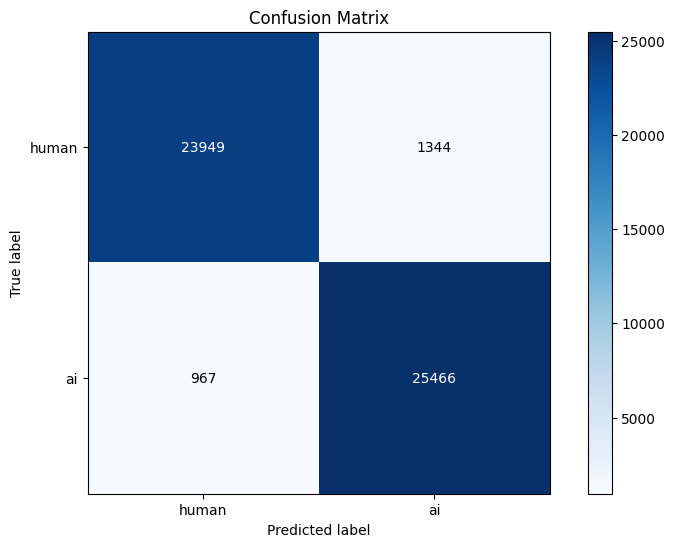

In [ ]:
skplt.metrics.plot_confusion_matrix(y_val, labels, normalize=False, figsize=(10,6))
plt.xticks([0, 1],['human', 'ai'])
plt.yticks([0, 1],['human', 'ai'])
plt.show()

## Catboost


In [ ]:
!pip install catboost

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
train.columns

Index(['text', 'text_lemmas'], dtype='object')

In [ ]:
df_train = train
df_test = test

Добавим переменную длинна всего текста


In [ ]:
df_train['sym_len'] = train.text_lemmas.apply(len)
df_train['word_len'] = train.text_lemmas.apply(lambda x: len(x.split()))

df_test['sym_len'] = test.text_lemmas.apply(len)
df_test['word_len'] = test.text_lemmas.apply(lambda x: len(x.split()))

Вимдим, что распредление с длинным хвостом, поэтому логорифмируем эти фичи

In [ ]:
df_train['sym_len'] = np.log(df_train['sym_len'])
df_train['word_len'] = np.log(df_train['word_len'])
df_test['sym_len'] = np.log(df_test['sym_len'])
df_test['word_len'] = np.log(df_test['word_len'])

In [ ]:
from catboost import CatBoostClassifier
from catboost import Pool


def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=5000,
        learning_rate=0.05,
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

In [ ]:
train_pool = Pool(
    df_train, y_train,
    text_features=['text','text_lemmas'],
)
test_pool = Pool(
    df_test, y_test,
    text_features=['text','text_lemmas'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model_cat_boost = fit_model(train_pool, test_pool)

Train dataset shape: (120691, 4)



0:	learn: 0.6691268	test: 0.6686489	best: 0.6686489 (0)	total: 46.2ms	remaining: 3m 50s
100:	learn: 0.3427428	test: 0.3383844	best: 0.3383844 (100)	total: 2.06s	remaining: 1m 40s
200:	learn: 0.2837454	test: 0.2804893	best: 0.2804893 (200)	total: 3.97s	remaining: 1m 34s
300:	learn: 0.2512431	test: 0.2492398	best: 0.2492398 (300)	total: 5.96s	remaining: 1m 33s
400:	learn: 0.2296954	test: 0.2289899	best: 0.2289899 (400)	total: 7.99s	remaining: 1m 31s
500:	learn: 0.2134233	test: 0.2139496	best: 0.2139496 (500)	total: 9.97s	remaining: 1m 29s
600:	learn: 0.2015024	test: 0.2030775	best: 0.2030775 (600)	total: 12.1s	remaining: 1m 28s
700:	learn: 0.1918362	test: 0.1945891	best: 0.1945891 (700)	total: 14.2s	remaining: 1m 26s
800:	learn: 0.1839596	test: 0.1879124	best: 0.1879124 (800)	total: 16.3s	remaining: 1m 25s
900:	learn: 0.1772065	test: 0.1822548	best: 0.1822548 (900)	total: 18.1s	remaining: 1m 22s
1000:	learn: 0.1717446	test: 0.1778470	best: 0.1778470 (1000)	total: 20s	remaining: 1m 20s
11

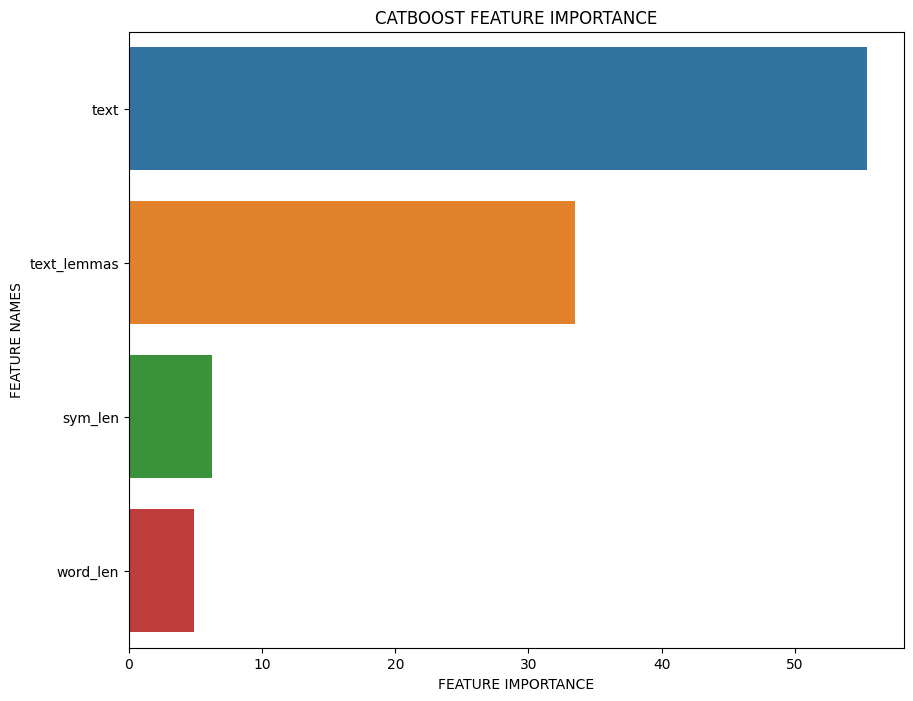

In [ ]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model_cat_boost .get_feature_importance(),df_train.columns,'CATBOOST ')

In [ ]:
y_pred = model_cat_boost.predict(test_pool)

In [ ]:
print('F1:',f1_score(y_pred, y_test, average='macro'))
print('Accuracy:',accuracy_score(y_pred, y_test))

F1: 0.9486269452650782
Accuracy: 0.9486525151761204


In [4]:
f1_score(y_pred, y_test, average='micro')

0.9486525151761204

In [18]:
precision_score(y_pred, y_test)

0.9477431860437517

In [19]:
recall_score(y_pred, y_test)

0.9472185980310758

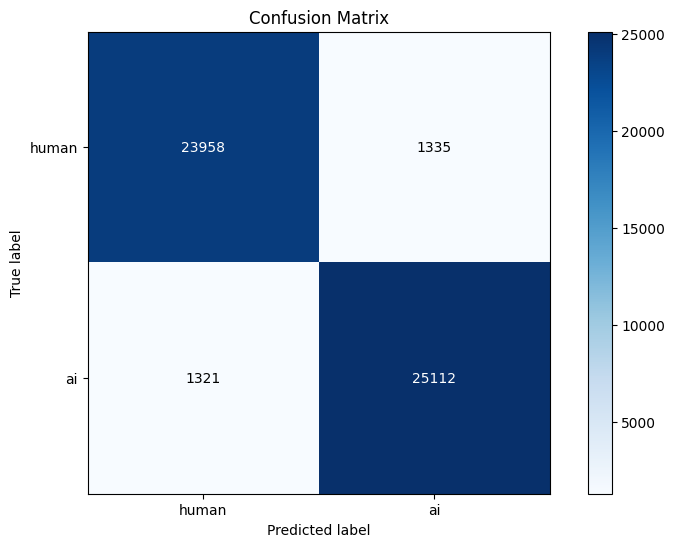

In [ ]:
y_pred = model_cat_boost.predict(test_pool)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, figsize=(10,6))
plt.xticks([0, 1],['human', 'ai'])
plt.yticks([0, 1],['human', 'ai'])
plt.show()

## DistilmBERT

In [ ]:
model_name = "distilbert-base-multilingual-cased"

classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data['text_f'] = data.apply(lambda x: " [CLS] " + x.text_lemmas.replace(".", " [SEP] "), axis=1)
data.sample(10)

,text,label,model,source,id,text_lemmas,text_f
101450,\n\nThis paper presents an interesting approac...,1,davinci,peerread,101450,This paper presents interesting approach prepo...,[CLS] This paper presents interesting approac...
61751,了。\n\n得到原谅不一定能靠做的多，更重要的是你要诚心悔改，要有耐心地去接受对方的情绪，去...,1,davinci,chinese,61751,得到原谅不一定能靠做的多，更重要的是你要诚心悔改，要有耐心地去接受对方的情绪，去深入了解对方...,[CLS] 得到原谅不一定能靠做的多，更重要的是你要诚心悔改，要有耐心地去接受对方的情绪，...
83594,Hunted (2015 TV series) is a British spy dram...,1,davinci,wikipedia,83594,Hunted (2015 series) British drama series mode...,[CLS] Hunted (2015 series) British drama seri...
29282,The Wounded Knee Massacre was one of the darke...,1,davinci,reddit,29282,Wounded Knee Massacre darkest moments American...,[CLS] Wounded Knee Massacre darkest moments A...
71492,"\nIn this paper, we utilize dynamical mean fie...",1,davinci,arxiv,71492,"paper, utilize dynamical mean field theory (DM...","[CLS] paper, utilize dynamical mean field the..."
86495,"Yes, Google Maps does assume that everyone fol...",1,davinci,reddit,86495,"Yes, Google Maps assume everyone follows speed...","[CLS] Yes, Google Maps assume everyone follow..."
14960,"Salmon, Jeff (born September 16, 1966) is the ...",1,bloomz,wikipedia,14960,"Salmon, Jeff (born September 1966) former mayo...","[CLS] Salmon, Jeff (born September 1966) form..."
80449,rs threshold of 0.0001;\nProofing - Set AutoCo...,1,davinci,wikihow,80449,threshold 0.0001; Proofing AutoCorrect English...,[CLS] threshold 0 [SEP] 0001; Proofing AutoCo...
157978,The underwater images usually suffers from n...,0,human,arxiv,157978,underwater images usually suffers non-uniform ...,[CLS] underwater images usually suffers non-u...
19405,Cavanaquill () is a townland in the civil pari...,0,human,wikipedia,19405,"Cavanaquill townland civil parish Templeport, ...",[CLS] Cavanaquill townland civil parish Templ...


In [ ]:
X_train, X_val, y_train, y_val = tts(data['text_f'], data['label'], random_state=42, test_size=0.3, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [ ]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    f1_false = f1_score(labels, preds, pos_label=0)
    f1_true = f1_score(labels, preds, pos_label=1)
    return {
            'f1 macro'      : f1,
            'f1 ai'          : f1_true,
            'f1 hu'       : f1_false
            }

In [ ]:
training_args = TrainingArguments(
    run_name = 'DistilmBERT',
    output_dir='./results',
    learning_rate=5e-5,
    max_steps = 5000,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    save_total_limit=4,
    load_best_model_at_end=True,
    logging_steps=500,
    save_steps=500,
    fp16=True,
    evaluation_strategy="steps")

trainer = Trainer(
    model=classifier.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,F1 macro,F1 ai,F1 hu
500,0.437500,0.269563,0.886148,0.896649,0.875647
1000,0.221600,0.239195,0.910055,0.917571,0.902540
1500,0.173200,0.177492,0.933694,0.937407,0.929980
2000,0.145000,0.150185,0.946546,0.949029,0.944063
2500,0.135900,0.115763,0.956402,0.957742,0.955063
3000,0.114900,0.122601,0.960333,0.961803,0.958863
3500,0.112900,0.110071,0.962719,0.964028,0.961411
4000,0.095800,0.281289,0.958251,0.960163,0.956339
4500,0.151200,0.585587,0.951998,0.954716,0.949280
5000,0.195600,0.475024,0.960011,0.961872,0.958149


TrainOutput(global_step=5000, training_loss=0.17835616760253906, metrics={'train_runtime': 10111.4306, 'train_samples_per_second': 15.824, 'train_steps_per_second': 0.494, 'total_flos': 2.119306170877747e+16, 'train_loss': 0.17835616760253906, 'epoch': 1.33})

In [ ]:
test_pred = trainer.predict(valid_dataset)
labels = test_pred[0].argmax(-1)

In [ ]:
f1_score(labels,y_val)

0.9640282395129057

In [10]:
accuracy_score(labels,y_val)

0.9627653404477439

In [11]:
f1_score(labels,y_val, average='micro')

0.9627653404477439

In [9]:
f1_score(labels,y_val, average='macro')

0.962719389241526

In [20]:
precision_score(labels,y_val)

0.9746110411504245

In [21]:
recall_score(labels,y_val)

0.9485628434744791

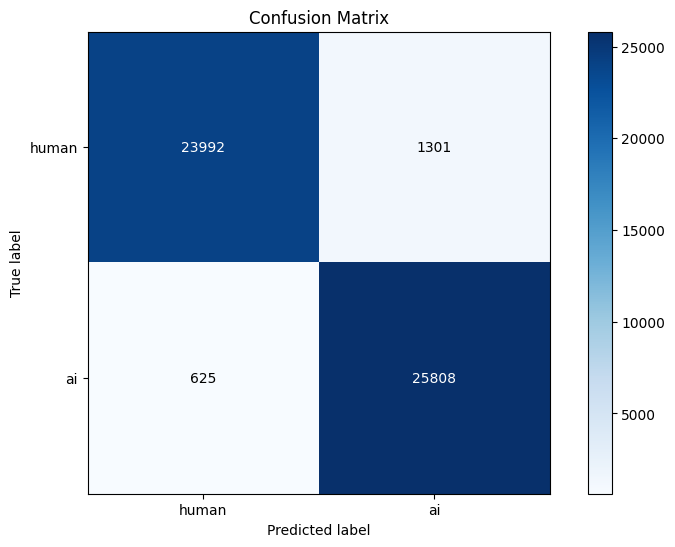

In [ ]:
skplt.metrics.plot_confusion_matrix(y_val, labels, normalize=False, figsize=(10,6))
plt.xticks([0, 1],['human', 'ai'])
plt.yticks([0, 1],['human', 'ai'])
plt.show()

# XLM-R

In [ ]:
model_name = "xlm-roberta-base"

classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data['text_f'] = data.apply(lambda x: " [CLS] " + x.text_lemmas.replace(".", " [SEP] "), axis=1)
data.sample(10)

,text,label,model,source,id,text_lemmas,text_f
101450,\n\nThis paper presents an interesting approac...,1,davinci,peerread,101450,This paper presents interesting approach prepo...,[CLS] This paper presents interesting approac...
61751,了。\n\n得到原谅不一定能靠做的多，更重要的是你要诚心悔改，要有耐心地去接受对方的情绪，去...,1,davinci,chinese,61751,得到原谅不一定能靠做的多，更重要的是你要诚心悔改，要有耐心地去接受对方的情绪，去深入了解对方...,[CLS] 得到原谅不一定能靠做的多，更重要的是你要诚心悔改，要有耐心地去接受对方的情绪，...
83594,Hunted (2015 TV series) is a British spy dram...,1,davinci,wikipedia,83594,Hunted (2015 series) British drama series mode...,[CLS] Hunted (2015 series) British drama seri...
29282,The Wounded Knee Massacre was one of the darke...,1,davinci,reddit,29282,Wounded Knee Massacre darkest moments American...,[CLS] Wounded Knee Massacre darkest moments A...
71492,"\nIn this paper, we utilize dynamical mean fie...",1,davinci,arxiv,71492,"paper, utilize dynamical mean field theory (DM...","[CLS] paper, utilize dynamical mean field the..."
86495,"Yes, Google Maps does assume that everyone fol...",1,davinci,reddit,86495,"Yes, Google Maps assume everyone follows speed...","[CLS] Yes, Google Maps assume everyone follow..."
14960,"Salmon, Jeff (born September 16, 1966) is the ...",1,bloomz,wikipedia,14960,"Salmon, Jeff (born September 1966) former mayo...","[CLS] Salmon, Jeff (born September 1966) form..."
80449,rs threshold of 0.0001;\nProofing - Set AutoCo...,1,davinci,wikihow,80449,threshold 0.0001; Proofing AutoCorrect English...,[CLS] threshold 0 [SEP] 0001; Proofing AutoCo...
157978,The underwater images usually suffers from n...,0,human,arxiv,157978,underwater images usually suffers non-uniform ...,[CLS] underwater images usually suffers non-u...
19405,Cavanaquill () is a townland in the civil pari...,0,human,wikipedia,19405,"Cavanaquill townland civil parish Templeport, ...",[CLS] Cavanaquill townland civil parish Templ...


In [ ]:
X_train, X_val, y_train, y_val = tts(data['text_f'], data['label'], random_state=42, test_size=0.3, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [ ]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    f1_false = f1_score(labels, preds, pos_label=0)
    f1_true = f1_score(labels, preds, pos_label=1)
    return {
            'f1 macro'      : f1,
            'f1 ai'          : f1_true,
            'f1 hu'       : f1_false
            }

In [ ]:
classifier

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [ ]:
training_args = TrainingArguments(
    run_name = 'XLM-R',
    output_dir='./results',
    learning_rate=5e-5,
    max_steps = 5000,
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    save_total_limit=4,
    load_best_model_at_end=True,
    logging_steps=500,
    save_steps=500,
    fp16=True,
    evaluation_strategy="steps")

trainer = Trainer(
    model=classifier.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,F1 macro,F1 ai,F1 hu
500,0.509000,0.434784,0.791603,0.829398,0.753808
1000,0.409500,0.290491,0.866554,0.883826,0.849282
1500,0.263700,0.230467,0.902390,0.912003,0.892777
2000,0.243000,0.244345,0.928504,0.932437,0.924572
2500,0.238200,0.192105,0.946281,0.948483,0.944079
3000,0.245600,0.634970,0.913448,0.921629,0.905267
3500,0.331500,0.828192,0.879961,0.896092,0.863830
4000,0.272200,0.561224,0.909225,0.918444,0.900006
4500,0.264500,0.721870,0.929381,0.934963,0.923800
5000,0.385900,0.614535,0.943976,0.947413,0.940539


TrainOutput(global_step=5000, training_loss=0.3163147796630859, metrics={'train_runtime': 17967.1412, 'train_samples_per_second': 4.453, 'train_steps_per_second': 0.278, 'total_flos': 2.10488844288e+16, 'train_loss': 0.3163147796630859, 'epoch': 0.66})

In [ ]:
test_pred = trainer.predict(valid_dataset)
labels = test_pred[0].argmax(-1)

In [ ]:
f1_score(labels,y_val)

0.9484827099505998

In [12]:
accuracy_score(labels,y_val)

0.9463712639678304

In [14]:
f1_score(labels,y_val, average='micro')

0.9463712639678304

In [15]:
f1_score(labels,y_val, average='macro')

0.9462810275955476

In [23]:
precision_score(labels,y_val)

0.9631061571998519

In [22]:
recall_score(labels,y_val)

0.9257897441979994

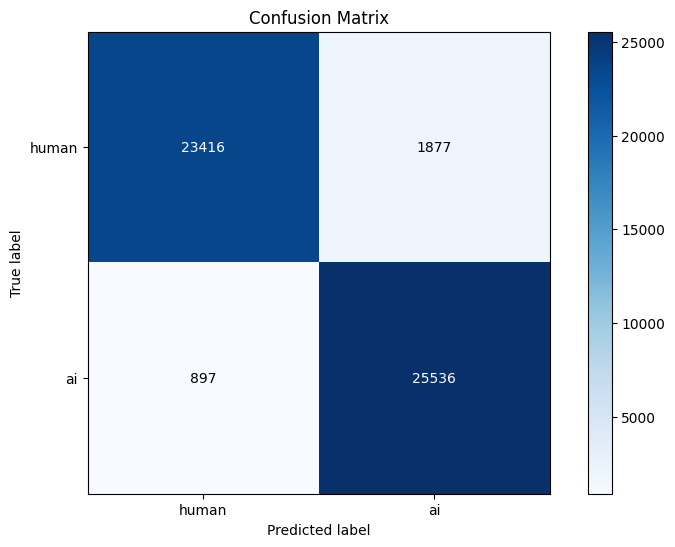

In [ ]:
skplt.metrics.plot_confusion_matrix(y_val, labels, normalize=False, figsize=(10,6))
plt.xticks([0, 1],['human', 'ai'])
plt.yticks([0, 1],['human', 'ai'])
plt.show()